In [2]:
# modules that you are likely to use

import xarray as xr
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Precipitation distribution

For this section you will use the following skills:

1. loading NetCDF files using `xarray.open_dataset` (or multiple files at once with `xarray.open_mfdataset`)
2. plotting scalar fields with geographical information such as coastlines and borders in a specific geographic projection using `cartopy`
3. doing data-range selection (in space and time) with `xarray.Dataset.sel`
4. binning datasets over time with `xarray.Dataset.groupby_bins` and making calculations on these bins
5. calculating mean over specific dimensions (e.g. time) with `xarray.Dataset.sel(...).mean(dim='time')`

From the paper:

> The observations show that
an MCS developed on 30 July and produced a large amount
of rainfall during the evening of 30 July and early morning
of 31 July (black circles in Figure 3(a) and (b)). This system
created patches of wet soil in the region 13–18 ◦ N, 4 ◦ W–3 ◦ E.
The parent storm initiated on the afternoon of 30 July
between 10–15 ◦ N and 5–10 ◦ E and tracked westwards until
it dissipated during the afternoon of 31 July between 2 ◦ W
and 2 ◦ E (light grey circles in Figure 3(a)–(d)). Even though
the details of the model rainfall distribution do not agree
well with the observations, the timing, general location and
propagation of these two systems are reproduced well by the
model (i.e. within 1 ◦ and 1 h, Figures 3(g)–(j)).

> The daughter MCS storm initiated during the afternoon
of 31 July at 16 ◦ N, 1 ◦ E, developed into a MCS during
late afternoon and then propagated towards the west on
1 August (marked by the dark grey circles in Figure 3(d)–(f)).
The system reached the west coast of Africa on 2 August
and began to dissipate (not shown). Again, the model
control simulation reproduces the timing, general location
and propagation of this system with good accuracy (Figure 3(j)–(l)), but the details of the initiation are different
to those suggested by the observations.

<img src='../figures/figure-3.png' width=500 />

**Figure 3: Six-hourly accumulated precipitation (mm 6 h −1 ) from TRMM3B42 ((a)–(f)) and the model control run ((g) and (l)) from 1800 UTC on
30 July 2006 to 0600 UTC on 1 August 2006. The black circles mark the MCS on 30 July that produced the wet soil patches, the light grey circles mark
the parent storm and the dark grey circles mark the daughter storm.**

In [4]:
# 1. Load the TRMM precipitation dataset (data/TRMM)
ds_trmm = xr.open_mfdataset('../data/TRMM/*.nc', concat_dim='time', preprocess=None, decode_times=True)

In [5]:
# 2. Create six-hourly accumulated precipitation by first binning and then summing over time

bins = ds_trmm.sel(time=slice('2006-07-30 18:00', '2006-08-01 06:00')).time[::2]
bins

<xarray.DataArray 'time' (time: 7)>
array(['2006-07-30T18:00:00.000000000', '2006-07-31T00:00:00.000000000',
       '2006-07-31T06:00:00.000000000', '2006-07-31T12:00:00.000000000',
       '2006-07-31T18:00:00.000000000', '2006-08-01T00:00:00.000000000',
       '2006-08-01T06:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2006-07-30T18:00:00 2006-07-31 ...

In [6]:
ds_trmm_binned = ds_trmm.groupby_bins('time', bins).sum(dim='time')

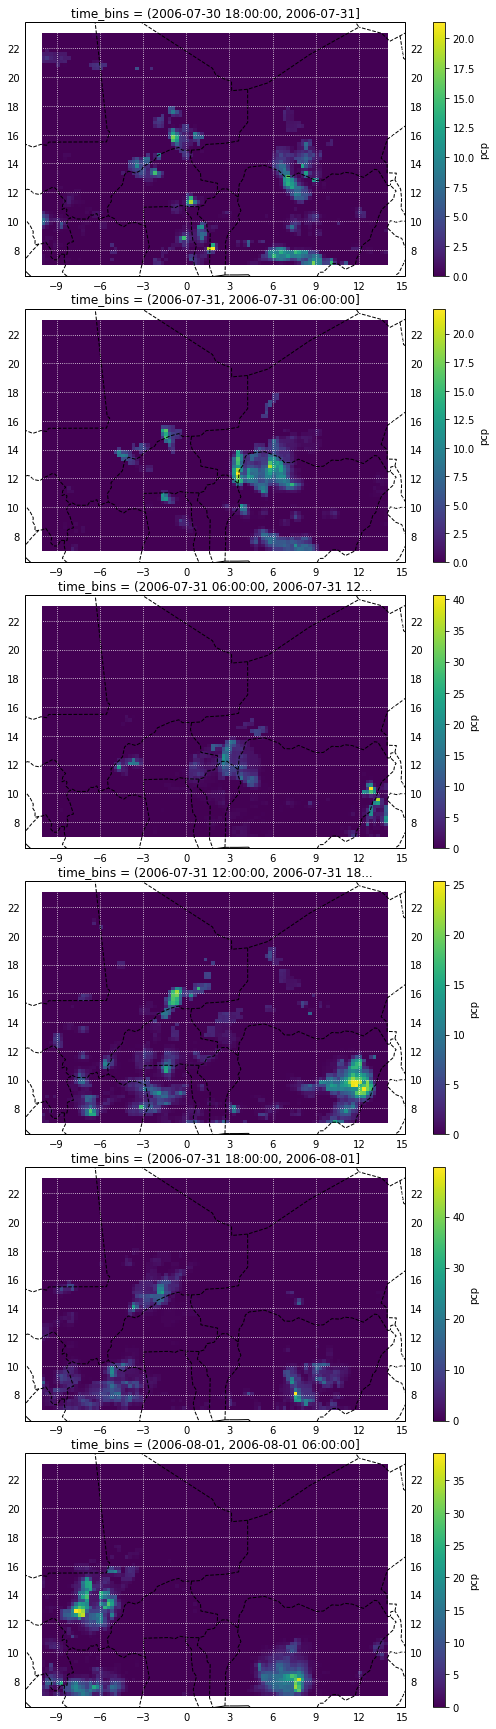

In [7]:
# 3. Use matplotlib.gridspec.GridSpec to create 1x3 subplots and plot precipitation.
#    Add coastlines, borders etc
n = len(ds_trmm_binned.time_bins)

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(8, 4*n))
gs = iter(GridSpec(n, 1))
projection = ccrs.PlateCarree()

for tb in ds_trmm_binned.time_bins.values:
    ax = plt.subplot(next(gs), projection=projection)
    ds_ = ds_trmm_binned.sel(time_bins=tb, longitude=slice(-10, 14), latitude=slice(7, 23))
    ds_.pcp.plot(ax=ax, transform=ccrs.PlateCarree())
    
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey')
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='white')
    gl.xlabels_top = False
    
plt.tight_layout()

## Precip distribution with storm locations

In [30]:
# 4. Create dictionary to store locations of storms, eg

parent_storm_locations = {
    '2006-07-30T18:00:00.000000000': (14, 9),
    '2006-07-30T21:00:00.000000000': (14, 8),
    '2006-07-31T00:00:00.000000000': (13, 7),
    '2006-07-31T03:00:00.000000000': (13, 6),
    '2006-07-31T06:00:00.000000000': (12.5, 3.5),
    '2006-07-31T09:00:00.000000000': (12, 3),
}
daughter_storm_locations = {
    '2006-07-31T15:00:00.000000000': (16, 0.5),
    '2006-07-31T18:00:00.000000000': (16, -1),
    '2006-07-31T21:00:00.000000000': (15, -1.7),
    '2006-08-01T00:00:00.000000000': (14, -4),
}

# 5. and function plot a circle marking the storm location at a given time

def plot_storm_loc(t):
    storm_loc = parent_storm_locations.get(t)
    if storm_loc is not None:
        ax.scatter(storm_loc[1], storm_loc[0], marker='o', s=2000, linewidth=2, color='red', facecolors='none')
    storm_loc = daughter_storm_locations.get(t)
    if storm_loc is not None:
        ax.add_artist(plt.Circle((storm_loc[1], storm_loc[0]), 3, color='orange', linewidth=5, fill=False))
        
def plot_storm_path(times):
    for t in times:
        p_loc = parent_storm_locations.get(str(t))
        if p_loc is not None:
            ax.plot(p_loc[1], p_loc[0], marker='s', color='red')
        d_loc = daughter_storm_locations.get(str(t))
        if d_loc is not None:
            ax.plot(d_loc[1], d_loc[0], marker='s', color='orange')       

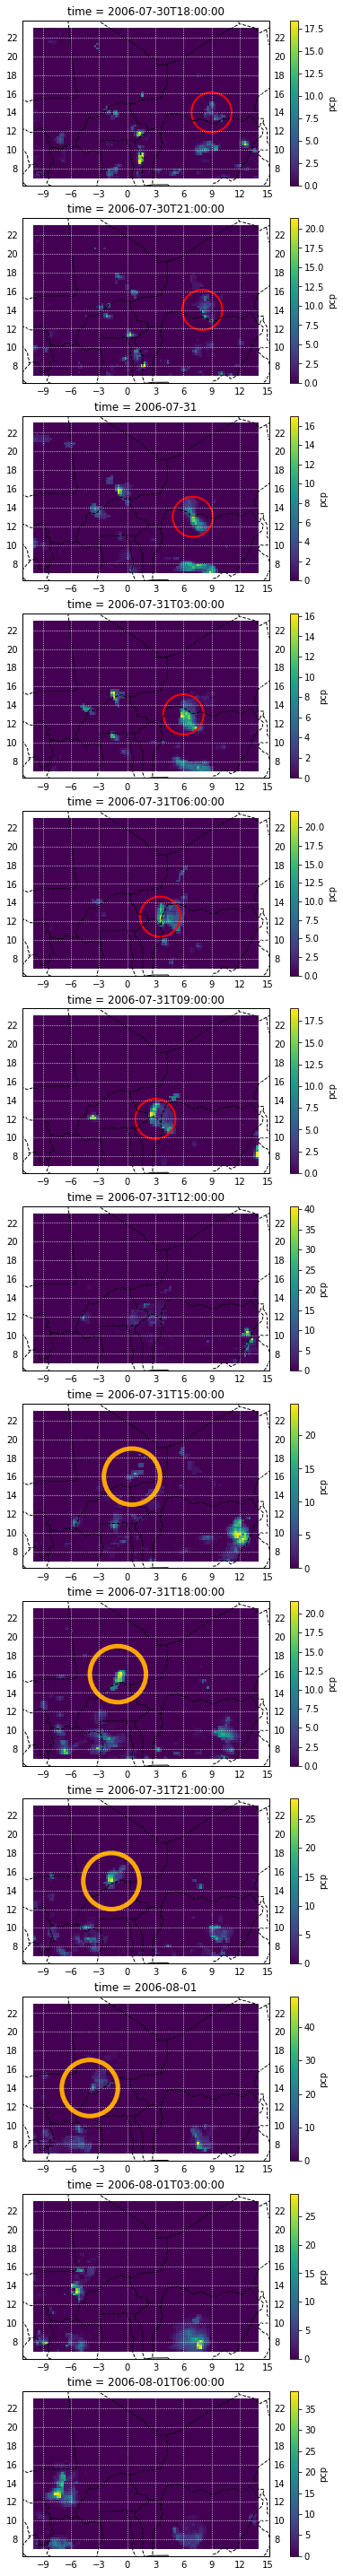

In [31]:
# 6. Recreate precipitation plot above with storm locations marked

ds_interval = ds_trmm.sel(time=slice('2006-07-30 18:00', '2006-08-01 06:00'))

n = len(ds_interval.time)

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(8, 4*n))
gs = iter(GridSpec(n, 1))
projection = ccrs.PlateCarree()

for t in ds_interval.time.values:
    ds_ = ds_interval.sel(time=t)
    
    ax = plt.subplot(next(gs), projection=ccrs.PlateCarree())
    ds_ = ds_.sel(longitude=slice(-10, 14), latitude=slice(7, 23))
    ds_.pcp.plot(ax=ax, transform=ccrs.PlateCarree())

    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey')
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='white')
    gl.xlabels_top = False

    plot_storm_loc(str(ds_.time.values))


# Hovmoller plot of precipitation

For this section you will use the following skills:

1. plotting scalar fields with geographical information such as coastlines and borders in a specific geographic projection using `cartopy`
2. doing data-range selection (in space and time) with `xarray.Dataset.sel`
3. calculating mean over specific dimensions (e.g. time) with `xarray.Dataset.sel(...).mean(dim='time')`

From the paper:

> The
TRMM3B42 product illustrates the westward propagation
of the parent storm (P) between 1200 UTC on 30 July
and 1200 UTC on 31 July, followed by the initiation
and propagation of the daughter storm (D). The system
to the west (WP), which produced the patches of wet
soil between 4 ◦ W and 3 ◦ E is also shown in the satellite
precipitation. The EPSAT-SG data have a higher temporal
and spatial resolution than the TRMM3B42 data and they
are derived from a combination of TRMM data, GPCP-
1dd (Global Precipitation Climatology Project) data and
multiple channels from the SEVIRI (Spinning Enhanced
Visible and Infrared Imager) instrument on the MSG
(Meteosat Second Generation) satellite. The propagation
of the three systems in the EPSAT-SG product is very similar
to that in the TRMM3B42 product, giving confidence in
the use of TRMM3B42 data for the comparisons with the
model.

<img src='../figures/figure-4.png'  width=500 />

** Figure 4: Hovmoller plots of precipitation rate (averaged between 11 and 18N
for (a) TRMM3B42, (b) EPSAT observations and (c)–(f) various
MetUM runs. The diagonal lines mark the track of the parent (P) and daughter (D) storms in the observations, the storm that produced the wet patches
on 30 July is marked by ‘WP’ in the observations and the dots mark the commencement of deep convection in the observations. **

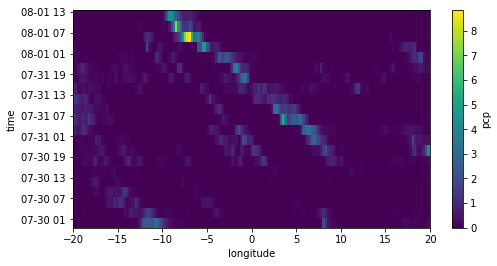

In [37]:
# 1. Select correct domain and timespan and average over latitude to create Hovmoller

ds_trmm.pcp.sel(latitude=slice(11, 18), longitude=slice(-20, 20))\
           .sel(time=slice('2006-07-30 00:00', '2006-08-01 12:00'))\
           .mean(dim='latitude').plot(aspect=2, size=4)

In [21]:
ds_tamsat = xr.open_mfdataset('data/TAMSAT/*.nc', concat_dim='time', preprocess=None, decode_times=True)
ds_tamsat

<xarray.Dataset>
Dimensions:  (lat: 1974, lon: 1894, time: 4)
Coordinates:
  * lon      (lon) float64 -19.01 -18.97 -18.94 -18.9 -18.86 -18.82 -18.79 ...
  * lat      (lat) float64 38.02 37.99 37.95 37.91 37.88 37.84 37.8 37.76 ...
  * time     (time) datetime64[ns] 2006-07-31 2006-08-01 2006-08-02 2006-08-03
Data variables:
    rfe      (time, lat, lon) float32 dask.array<shape=(4, 1974, 1894), chunksize=(1, 1974, 1894)>
Attributes:
    title:        TAMSAT Rain Fall Estimate (RFE) - Version 3.0
    institution:  TAMSAT Research Group, Meteorology Department, University o...
    contact:      tamsat@reading.ac.uk
    Conventions:  CF-1.5
    history:      Processed from TIR archive using satop with max_gap[mins]=360
    latmin:       -35.9625
    latmax:       38.025
    lonmin:       -19.0125
    lonmax:       51.975
    latres:       0.0375
    lonres:       0.0375

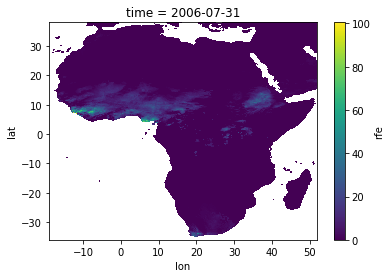

In [22]:
ds_tamsat.isel(time=0).rfe.plot()

/home/earlcd/anaconda2/envs/ghana-training-skills/lib/python3.5/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


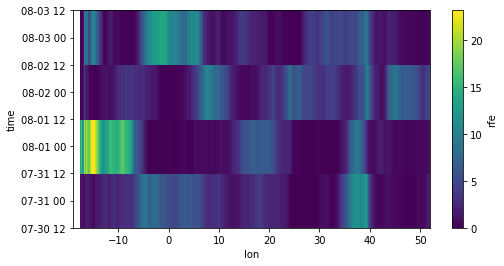

In [23]:
ds_tamsat.sel(lat=slice(18, 11)).mean(dim='lat').rfe.plot(aspect=2, size=4)

# Horizontal cross-sections of potential temperature

For this section you will use the following skills:

1. deriving and defining new scalar fields
2. plotting scalar fields with geographical information such as coastlines and borders in a specific geographic projection using `cartopy`
3. doing data-range selection (in space and time) with `xarray.Dataset.sel`

From the paper:

> In the control simulation and the
simulation initialized at 1200 UTC on 31 July the daughter
storm develops in a region of synoptic-scale convergence
(marked by the black contour lines and the ‘D’ in Figures 5(a)
and 5(b) respectively). This convergence zone forms through
the confluence of the moist, southerly winds associated with
the parent storm (‘P’) and the westerly winds associated
with the cyclonic circulation around the heat low. The
leading edge of the simulated cold pool produced by ‘P’ is
more than 100 km to the southeast of the daughter storm
initiation point at 1200 UTC, on 31 July (e.g. see Figure 16
and associated discussion) and therefore cannot directly
influence this convergence zone. Kl ̈upfel et al. (2011b)
conducted a sensitivity simulation of this case, in which
the evaporative cooling is removed from their simulation,
which suppresses the cold pool from the parent storm. They
demonstrate from this that the parent storm does indeed
modify the southerly monsoon flow and is a significant
factor in the development of this low-level convergence
zone, but this is not caused directly by the cold pool.

> The synoptic circulation in the simulation initialized at
0000 UTC on 31 July (Figure 5(e) and (f)) is different to the
two simulations described above. Neither the parent storm
nor the southerly winds north of it are reproduced by the model, and therefore the large-scale convergence zone does not develop. Without this convergence zone the daughter storm is not reproduced (Figure 4(f)).

<img src="../figures/figure-5.png" width=500 />

** Figure 5: (a), (c) and (e) 925 hPa potential temperature (shading), a contour of 925 hPa convergence (black lines) and 925 hPa wind vectors for the
model simulations initialized at 1200 UTC on 30 July (control), 1200 UTC on 31 July and 0000 UTC on 31 July respectively. The contour of convergence
in (a) and (e) is at 3 × 10 −5 s −1 and in (c) is at 1 × 10 −5 s −1 . 925 hPa specific humidity (shading) and 925 hPa wind vectors are shown in (b), (d) and
(f). All model diagnostics are at 1200 UTC, 31 July 2006. The black diagonal line shows the transect used in other plots. **

In [33]:
# 1. Were will again use the ERA-Interim dataset

ds_ei_plevels = xr.open_mfdataset('../data/ERA-Interim/ei_model_levels.nc')
ds_ei_sfc = xr.open_mfdataset('../data/ERA-Interim/ei_surface.nc')
ds_ei = xr.merge([ds_ei_plevels, ds_ei_sfc])

Potential temperature $\theta$ definition:

$\theta = T \left(\frac{p_0}{p} \right)^{R_d/cp_d}$,

where the dry gas constant, heat capacity at constant pressure and reference pressure are

$R_d$ = 287.04 kJ/kg/K   
$c_{p,d}$ = 1004.6 kJ/kg/K  
$p_0$ = 1000.0hPa

reference: https://rda.ucar.edu/datasets/ds627.1/docs/Pressure_and_isentropic_levels/

In [34]:
# 2. Calculate the potential temperature and create a new xarray.DataArray and add it to your dataset

R_d = 0.28704*1.0e3 # [J/kg/K]
cp_d = 1.0046*1.0e3 # [J/kg/K]
p0 = 1000.0  # hPa

theta = ds_ei.t*(p0/ds_ei.level)**(R_d/cp_d)
ds_ei['theta'] = (ds_ei.t.dims, theta, dict(units='K', long_name='potential temperature'))

In [35]:
theta

<xarray.DataArray (time: 16, level: 27, latitude: 68, longitude: 102)>
dask.array<shape=(16, 27, 68, 102), dtype=float64, chunksize=(16, 27, 68, 102)>
Coordinates:
  * longitude  (longitude) float32 -25.5 -24.75 -24.0 -23.25 -22.5 -21.75 ...
  * latitude   (latitude) float32 45.0 44.25 43.5 42.75 42.0 41.25 40.5 ...
  * level      (level) int32 100 125 150 175 200 225 250 300 350 400 450 500 ...
  * time       (time) datetime64[ns] 2006-07-30 2006-07-30T06:00:00 ...

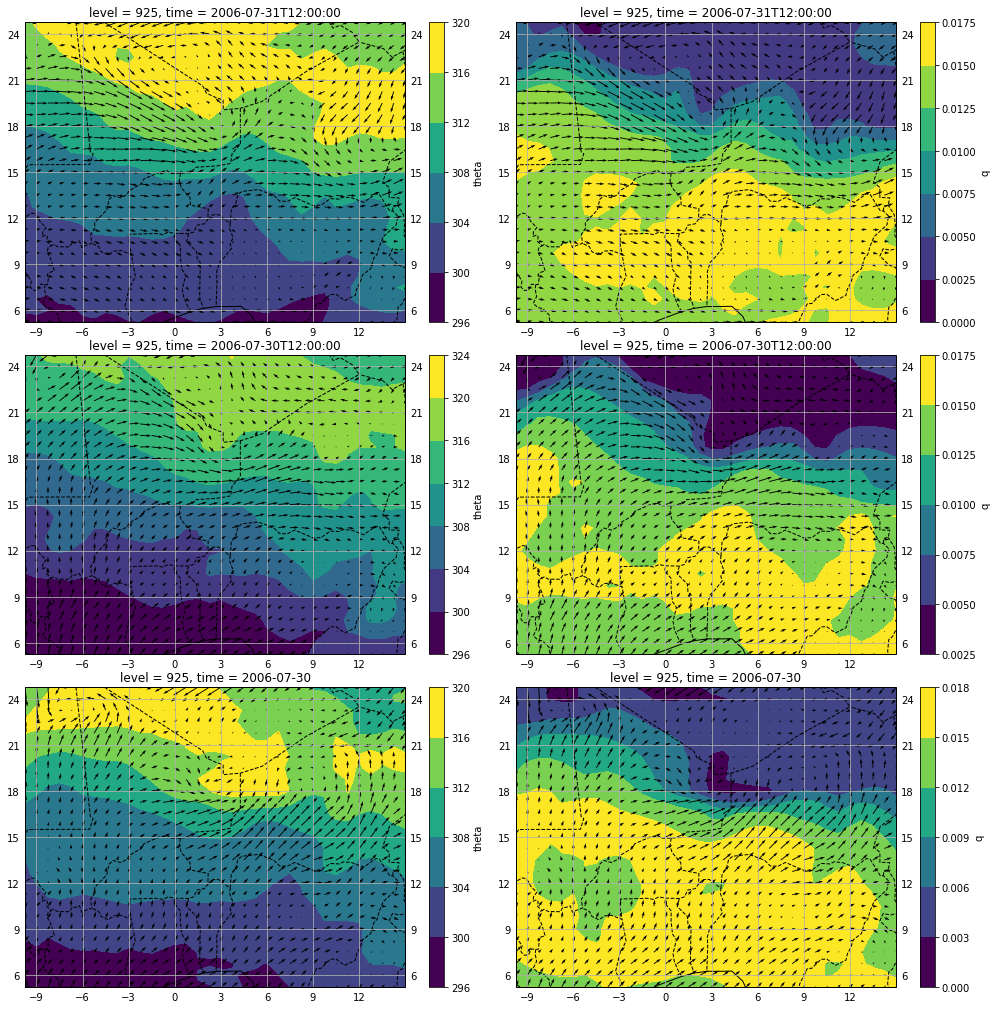

In [37]:
# 3. Use matplotlib's GridSpec to plot 2x3 grid of figures with potential temperature and specific 
# water vapour at the heights and timesteps mentioned above

from matplotlib.gridspec import GridSpec

gs = iter(GridSpec(3,2))
times = [
    '2006-07-31 12:00',
    '2006-07-30 12:00',
    '2006-07-30 00:00'
]

fig = plt.figure(figsize=(14,14))

for t in times:
    ds_ = ds_ei.sel(time=t).sel(level=925, longitude=slice(-10, 15), latitude=slice(25, 5))

    ax = plt.subplot(next(gs), projection=ccrs.PlateCarree())
    ds_.theta.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
    plt.quiver(*np.meshgrid(ds_.longitude, ds_.latitude, indexing='xy'), ds_.u, ds_.v)

    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    
    ax = plt.subplot(next(gs), projection=ccrs.PlateCarree())
    ds_.q.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
    plt.quiver(*np.meshgrid(ds_.longitude, ds_.latitude, indexing='xy'), ds_.u, ds_.v)

    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    
plt.tight_layout()